In [1]:
import deepchem as dc
import pandas as pd
import numpy as np

import xgboost as xgb
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

import ast
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
plt.rcParams['figure.dpi'] = 300

from sklearn.preprocessing import LabelEncoder

Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading some PyTorch models, missing a dependency. No module named 'torch'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'torch'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [2]:
data = pd.read_csv('../../data/BST.csv',encoding = 'gb2312')

# 特征提取

In [3]:
featurizer = dc.feat.RDKitDescriptors()
features = featurizer.featurize(data['SMILES'])
#dataset = dc.data.NumpyDataset(features,data['Label'])

In [4]:
nan_columns = np.isnan(features).any(axis=0)
deleted_columns = np.where(nan_columns)[0]
features_without_nan = features[:,~nan_columns]

In [5]:
from sklearn.feature_selection import VarianceThreshold

# 初始化VarianceThreshold对象
vt = VarianceThreshold(threshold = (.98 * (1 - .98)))

# 进行特征选择
X_new = vt.fit_transform(features)
dataset = dc.data.NumpyDataset(X_new,data['Label'],ids=data['SMILES'])

## 数据划分

In [11]:
splitter = dc.splits.RandomSplitter()
train_dataset,test_dataset = splitter.train_test_split(dataset=dataset,frac_train=0.8,seed=100)

# Multi-label

In [7]:
train_dataset_y = [ast.literal_eval(label) for label in train_dataset.y]
test_dataset_y  = [ast.literal_eval(label) for label in test_dataset.y]
train_new_y = MultiLabelBinarizer().fit_transform(train_dataset_y)
test_new_y = MultiLabelBinarizer().fit_transform(test_dataset_y)

# Data distribution ratio

In [8]:
def row_counter(my_array):
    list_of_tups = [tuple(ele) for ele in my_array]
    return Counter(list_of_tups)

In [9]:
print('train_dataset:',row_counter(train_new_y))
train_counter = row_counter(train_new_y)
print('Bitter : Sweet : Tasteless = ',train_counter[(1, 0, 0)]/10420,':',train_counter[(0, 1, 0)]/10420,':',train_counter[(0, 0, 1)]/10420)
print('test_dataset:',row_counter(test_new_y))
test_counter = row_counter(test_new_y)
print('Bitter : Sweet : Tasteless = ',test_counter[(1, 0, 0)]/2606,':',test_counter[(0, 1, 0)]/2606,':',test_counter[(0, 0, 1)]/2606)

train_dataset: Counter({(0, 1, 0): 4883, (0, 0, 1): 3961, (1, 0, 0): 1576})
Bitter : Sweet : Tasteless =  0.15124760076775431 : 0.4686180422264875 : 0.38013435700575815
test_dataset: Counter({(0, 1, 0): 1216, (0, 0, 1): 1020, (1, 0, 0): 370})
Bitter : Sweet : Tasteless =  0.1419800460475825 : 0.46661550268610896 : 0.3914044512663085


# GridSearchCV

In [10]:
scoring = {
     'F1_score': make_scorer(f1_score,average ='macro'),
     'Accuracy': make_scorer(accuracy_score),
     'Recall': make_scorer(recall_score,average = 'macro'),
     'Precision':make_scorer(precision_score,average = 'macro'),
}

param_grid = {'estimator__n_estimators':[200],
                  'estimator__max_depth':[17,19,21,23,25],
                  'estimator__colsample_bytree':[0.3,0.5,0.7,0.9],
                 'estimator__learning_rate':[0.01,0.05, 0.1,0.15,0.2]
                 }

In [12]:
classifier = xgb.XGBClassifier()
ovr = OneVsRestClassifier(classifier)

gs = GridSearchCV(
                    ovr,
                    param_grid,
                    scoring = scoring,
                    cv = KFold(n_splits=5, shuffle=True, random_state=100),
                    n_jobs = -1,
                    refit = 'F1_score',
                    return_train_score = True)

gs_fit = gs.fit(train_dataset.X,train_new_y)

In [13]:
val_F1 = gs.best_score_
val_ACC = gs.cv_results_['mean_test_Accuracy'][gs.best_index_]
val_Recall = gs.cv_results_['mean_test_Recall'][gs.best_index_]
val_Precision = gs.cv_results_['mean_test_Precision'][gs.best_index_]

In [14]:
print('Best parameters: ', gs.best_params_)
print('Best score (F1): ', val_F1)
print('Accuracy:',val_ACC)
print('Recall:',val_Recall)
print('Precision:',val_Precision)

Best parameters:  {'estimator__colsample_bytree': 0.3, 'estimator__learning_rate': 0.2, 'estimator__max_depth': 17, 'estimator__n_estimators': 200}
Best score (F1):  0.841035434124508
Accuracy: 0.8340690978886757
Recall: 0.8058198366222747
Precision: 0.8828726334264406


In [15]:
model_multi = gs_fit.best_estimator_
model_multi

OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.3,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.2, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=17,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...))

# Evaluate model

In [16]:
y_test_pred = model_multi.predict(test_dataset.X)
y_test_pred

array([[0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]])

In [17]:
# 将真实标签和预测标签转换为整数形式
y_true = np.argmax(test_new_y, axis=1)
y_pred = np.argmax(y_test_pred, axis=1)

In [18]:
# 将标签转换为整数形式
label_encoder = LabelEncoder()
y_true = label_encoder.fit_transform(y_true)
y_pred = label_encoder.transform(y_pred)

In [19]:
cm = confusion_matrix(y_true, y_pred)

In [20]:
cm

array([[ 306,   26,   48],
       [  69, 1145,   46],
       [ 104,   62,  800]], dtype=int64)

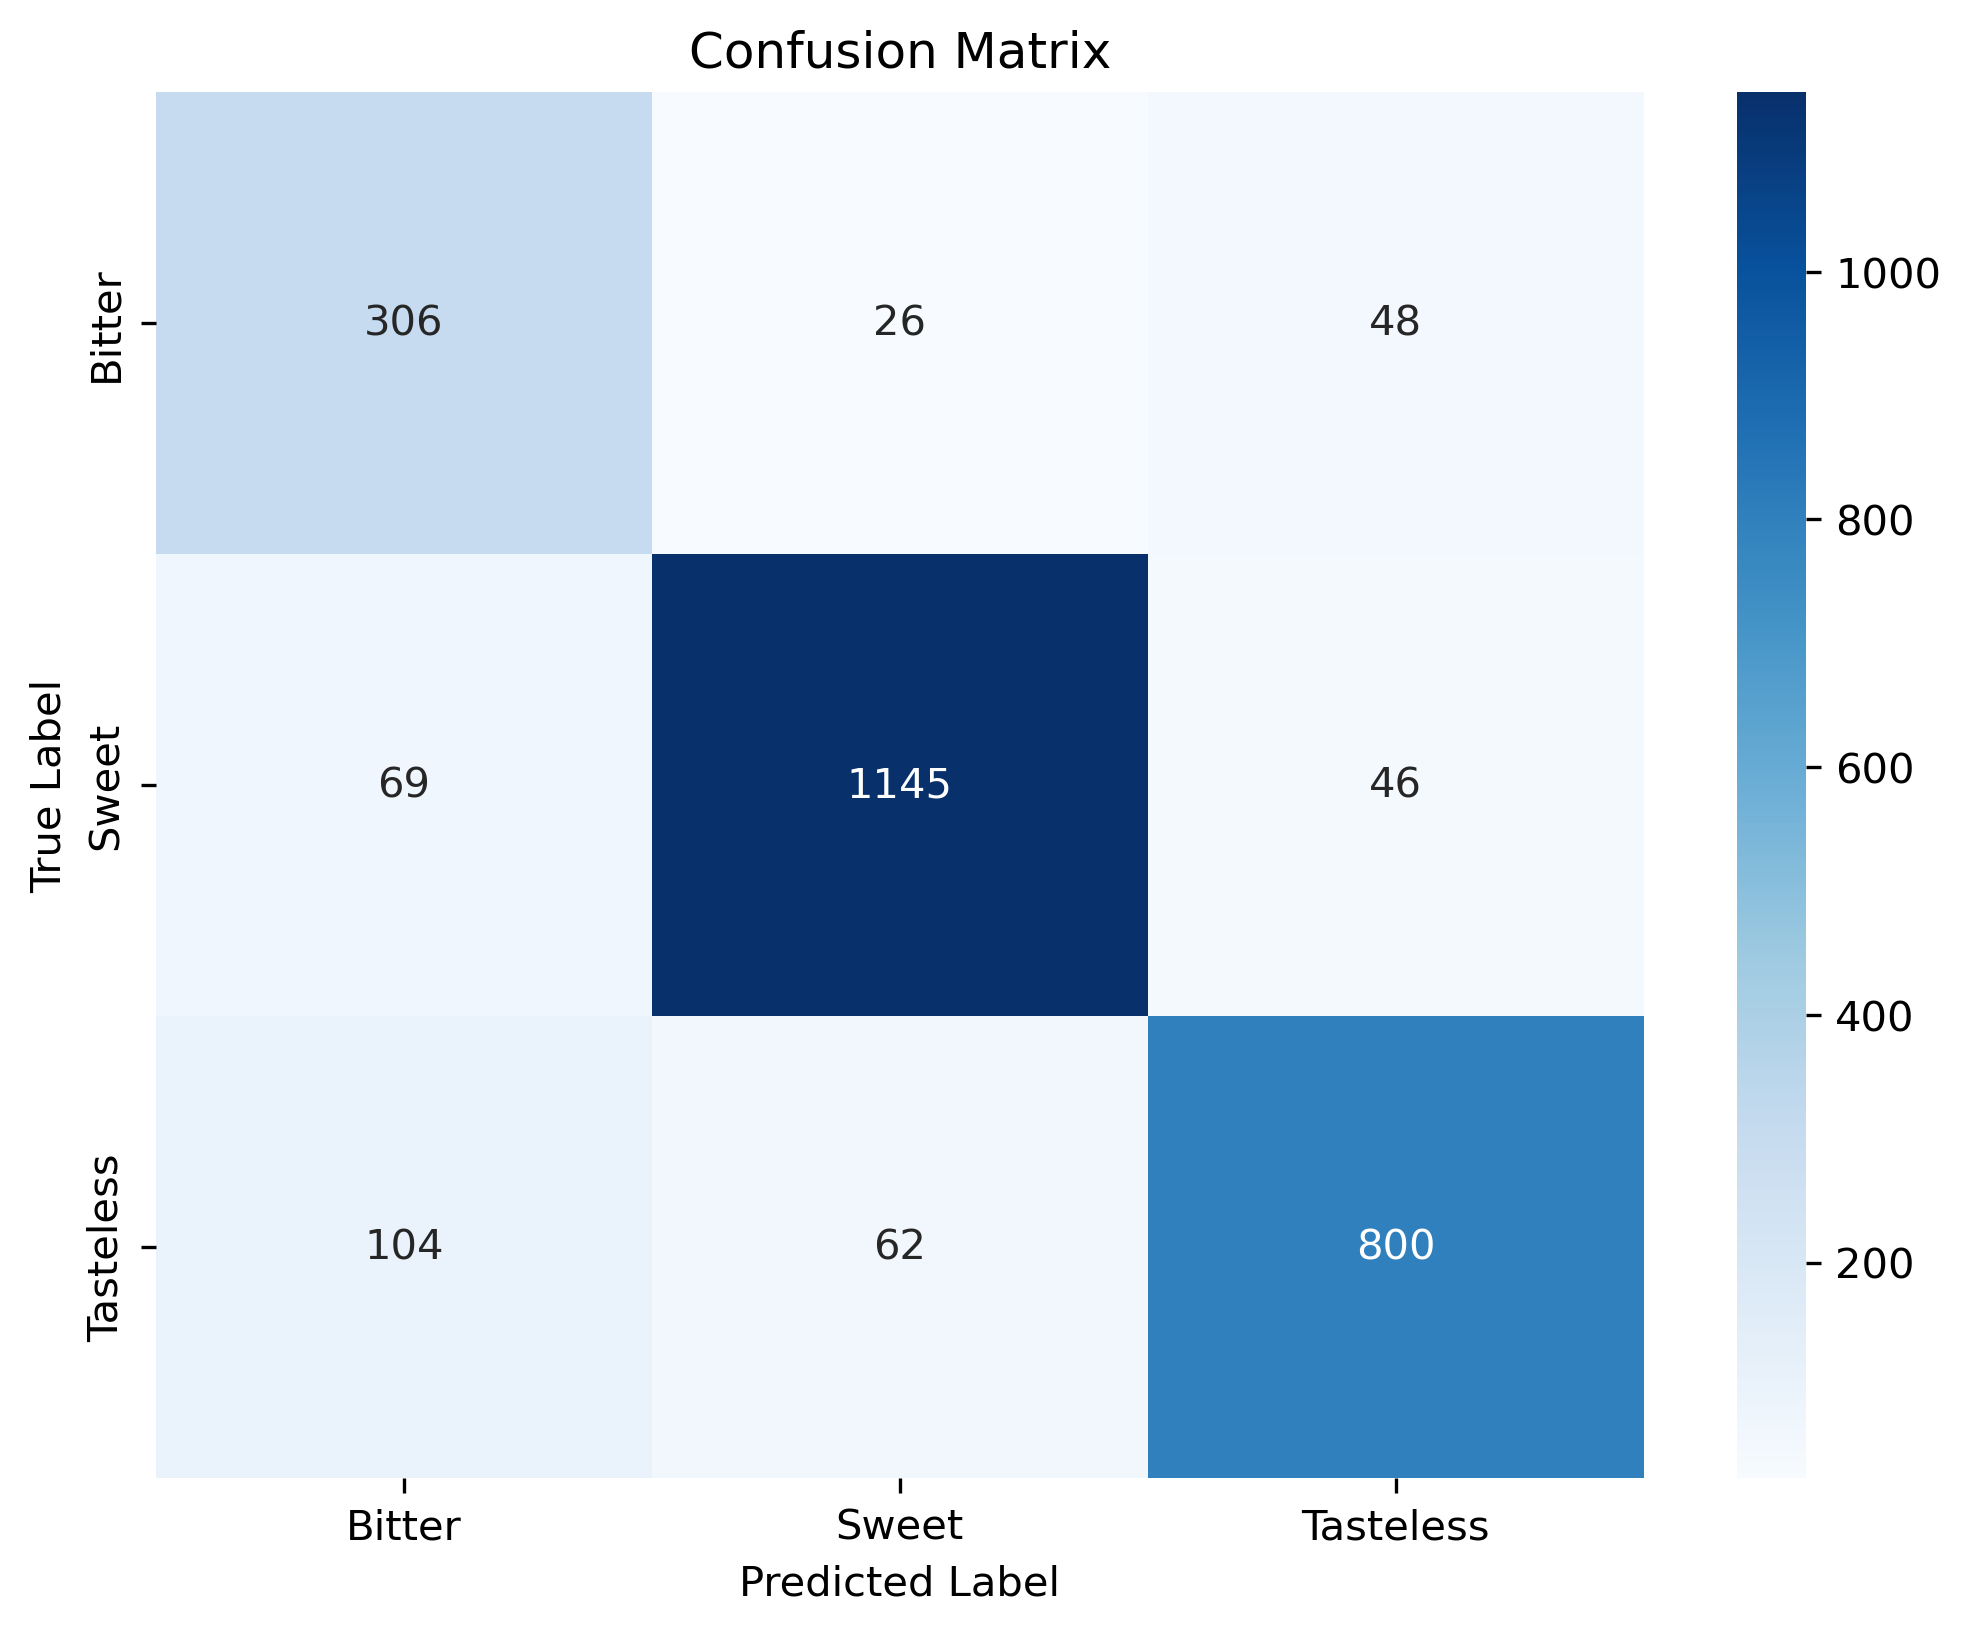

In [21]:
class_names = label_encoder.classes_  # 类别名称

# 绘制混淆矩阵图
class_names = ['Bitter', 'Sweet', 'Tasteless']  # 类别名称

# 标准化混淆矩阵
#cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 绘制热力图
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [22]:
test_F1 = f1_score(test_new_y, y_test_pred,average ='macro')
test_ACC = accuracy_score(test_new_y, y_test_pred)
test_Recall = recall_score(test_new_y,y_test_pred,average = 'macro')
test_Precision = precision_score(test_new_y, y_test_pred,average = 'macro')

In [23]:
rf_performance_dataset = {
    'F1_score':[val_F1,test_F1],
    'ACC':[val_ACC,test_ACC],
    'Recall':[val_Recall,test_Recall],
    'Precision':[val_Precision,test_Precision],
}

In [24]:
rf_performance = pd.DataFrame(rf_performance_dataset,index=['val','test'])
rf_performance

,F1_score,ACC,Recall,Precision
val,0.841035,0.834069,0.805820,0.882873
test,0.844444,0.839601,0.811751,0.883306
